# Understanding the Dataset and exploring preprocessing methodologies
## About the Notebook
The notebook contains code used for understanding the features of the dataset like the area of the building, the numnber of floors in it, and the distribution of data points. Further, we explore the various network architectures and compare their performance among each other. 

The effect of feature selection and preprocessing is also given. The notebooks were run on the kaggle platform for training purposes. **Since the initial weights of the deep neural net are random, the accuracies might not match with the accuracies
given in the publication.**

### Table of Contents
* [1. Importing all modules](#1)
* [2. Reading pickeled train data and view of the dataset](#2)
* [3. Understanding the dataset: fingerprints location in the building](#3)
* [4. Understanding the dataset: Number and location of signals heard per Access Point](#4)
* [5. Understanding the dataset: Number of Data Points per floor and Device model](#5)
* [6. Experiments: Effect of Preprocessing](#6)
* [7. Experiments: Effect of Feature Selection](#7)

<a id="1"></a>
### 1. Importing all modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy import genfromtxt
import matplotlib as mpl
from matplotlib import pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

['localization-1-12-x', 'localization-0-3-x', 'localization-0-12', 'localization-0-12-z', 'localization-1-12-z', 'creating-dataset', 'localization-1-3-x', 'localization-1-3-z', 'localization-0-12-x', 'localization-1-3', 'localization-0-3', 'creation-main', 'localization-0-3-z', 'localization-1-12', 'fingerprints-crowdsourced-wireless-localization']


<a id="2"></a>
### 2. Reading pickeled train data and view of the dataset

The same random splits were used across all notebooks to maintain fair comparision.

In [2]:
train_data_org = pd.read_pickle('../input/creation-main/train_index')
device_org=pd.read_pickle('../input/creation-main/device')
big_data_org = pd.read_pickle('../input/creation-main/big_data')
test_data_org = pd.read_pickle('../input/creation-main/test_index')

train_target_x_org = pd.read_pickle('../input/creation-main/train_x')
train_target_y_org = pd.read_pickle('../input/creation-main/train_y')
train_target_z_org = pd.read_pickle('../input/creation-main/train_z')
test_target_x_org = pd.read_pickle('../input/creation-main/test_x')
test_target_y_org = pd.read_pickle('../input/creation-main/test_y')
test_target_z_org = pd.read_pickle('../input/creation-main/test_z')

test_data_noprs = test_data_org.replace({0:100})
train_data_noprs = train_data_org.replace({0:100})

train_data_org.iloc[:10]


,0,1,2,3,4,5,6,7,8,9,...,982,983,984,985,986,987,988,989,990,991
1636,0,0,0,-83,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-72,0,0,0,0,0,0
1235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
579,0,0,0,0,0,0,0,-77,-79,-77,...,0,0,0,0,0,0,0,0,0,0
4237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2420,0,0,0,0,0,0,0,-66,-60,-60,...,0,0,0,0,0,0,0,0,0,0


<a id="3"></a>
### 3. Understanding the dataset: fingerprints location in the building
There are fixed Access Points located throughout the building, which are heard by these mobile users. The locations of all the data points that were sent to the server are shown below.

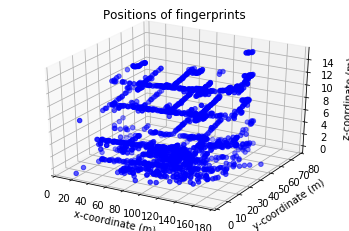

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_target_x[2000:],train_target_y[2000:],train_target_z[2000:], c='b', marker='o')
ax.set_title('Positions of fingerprints')
ax.set_xlabel('x-coordinate (m)')
ax.set_ylabel('y-coordinate (m)')
ax.set_zlabel('z-coordinate (m)')
ax.axis([0,180,0,80])
fig.savefig('fingerprints_location.png', bbox_inches='tight')

<a id="4"></a>
### 4. Understanding the dataset: Number and location of signals heard per Access Point

### Amount of measurements per access point
The amount of measurements per access point is depicted in the graph below. The number of measurements per access point is related to the location of access points. 

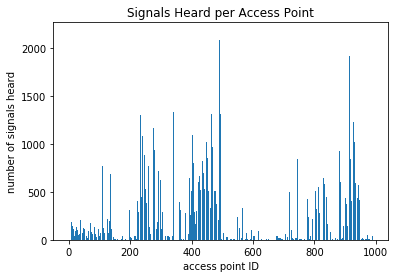

In [4]:
numFpPerAp = np.zeros((992), dtype=np.int)
for i in range(0,992):
    numFpPerAp[i] = big_data.shape[0]-big_data.iloc[:,i].value_counts()[0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(0,992), numFpPerAp)
ax.set_title('Signals Heard per Access Point');
ax.set_xlabel('access point ID');
ax.set_ylabel('number of signals heard');

plt.draw()
fig.savefig('nofaps.png', bbox_inches='tight')

### Heard Often: 3D view of the RSS values received by Access Point 492
Access points that are located centrally in the building, e.g., in the center of the building, on floors that are easily accessible and frequently passed by users, are likely to be heard often as shown in the graph below

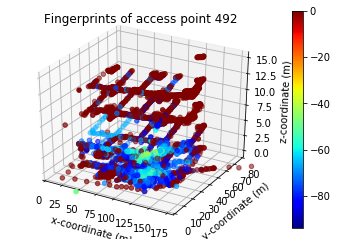

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(big_data.iloc[:,992],big_data.iloc[:,993],big_data.iloc[:,994], c=big_data.iloc[:,491], cmap='jet', marker='o')
fig.colorbar(p, ax=ax)
ax.set_title('Fingerprints of access point 492')
ax.set_xlabel('x-coordinate (m)')
ax.set_ylabel('y-coordinate (m)')
ax.set_zlabel('z-coordinate (m)')
ax.axis([0,180,0,80])
plt.draw()
fig.savefig('AP492.png', bbox_inches='tight')

### Heard Scarcely: 3D view of the RSS values received by Access Point 900
Access points in the corners that will be received at a edge of the building are likely to be heard scarcely as shown below.

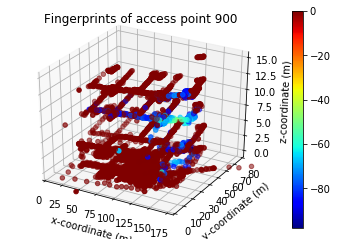

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(big_data.iloc[:,992],big_data.iloc[:,993],big_data.iloc[:,994], c=big_data.iloc[:,899], cmap='jet', marker='o')
fig.colorbar(p, ax=ax)
ax.set_title('Fingerprints of access point 900')
ax.set_xlabel('x-coordinate (m)')
ax.set_ylabel('y-coordinate (m)')
ax.set_zlabel('z-coordinate (m)')
ax.axis([0,180,0,80])
plt.draw()
fig.savefig('AP900.png', bbox_inches='tight')

### Never Heard: 3D view of the RSS values received by Access Point 600
Access points that are not even in the building are likely to be never heard.

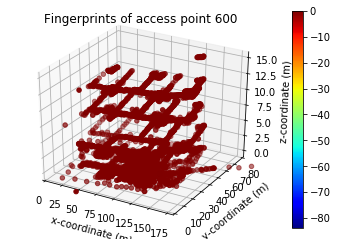

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(big_data.iloc[:,992],big_data.iloc[:,993],big_data.iloc[:,994], c=big_data.iloc[:,599], cmap='jet', marker='o')
fig.colorbar(p, ax=ax)
ax.set_title('Fingerprints of access point 600')
ax.set_xlabel('x-coordinate (m)')
ax.set_ylabel('y-coordinate (m)')
ax.set_zlabel('z-coordinate (m)')
ax.axis([0,180,0,80])
plt.draw()
fig.savefig('AP600.png', bbox_inches='tight')

<a id="5"></a>
### 5. Understanding the dataset: Number of Data Points per floor and Device model
We can see in the graph below that a few devices hardly contribute to the database, and there are some devices which have a significant contribution. We shall pay special attention to the devices having significant contribution, training separate model for these for performance comparison.

['Letv x600', 'Sony E5823', 'samsung SM-A310F', 'LGE LG-D625', 'samsung SM-A510F', 'HUAWEI Y360-U61', 'Meizu MX4 Pro', 'HUAWEI T1 7.0', 'asus Transformer Prime TF201', 'asus Nexus 7', 'Xiaomi MI 4LTE', 'Xiaomi MI MAX 2', 'motorola XT1068', 'Sony SGP771', 'LGE LG-H815', 'LENOVO Lenovo A6020a40', 'Meizu PRO 5', 'samsung SM-N910F', 'Obi SF1', 'motorola Nexus 6', 'HTC One M9']


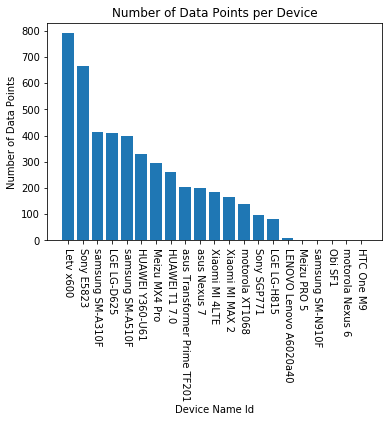

In [8]:
d = device['995'].value_counts()
print(d.index.tolist())
numDpPerDev = np.zeros((992), dtype=np.int)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(0,21), d)
ax.set_title('Number of Data Points per Device');
ax.set_xlabel('Device Name Id');
ax.set_ylabel('Number of Data Points');
plt.xticks(range(0,21), d.index.tolist(),rotation=270)
plt.draw()
fig.savefig('nofdpPerDev.png', bbox_inches='tight')

### Number of Data Points per floor
The distribution of measurements per floor is shown below for the entire database. Very few measurements were done in the 5th floor, as it was not accessible.

[0.0, 3.7, 7.4, 11.1, 14.8]


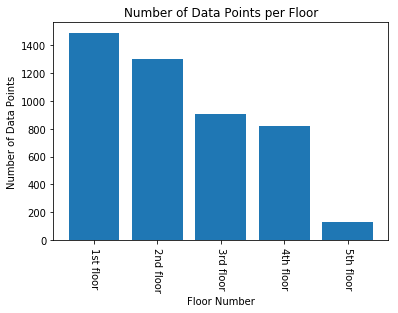

In [9]:
f = big_data['994'].value_counts()
print(f.index.tolist())
numDpPerDev = np.zeros(big_data.shape[0], dtype=np.int)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(0,5), f)
ax.set_title('Number of Data Points per Floor');
ax.set_xlabel('Floor Number');
ax.set_ylabel('Number of Data Points');
plt.xticks(range(0,5), ['1st floor','2nd floor','3rd floor','4th floor','5th floor'],rotation=270)
plt.draw()
fig.savefig('nofdpPerfloor.png', bbox_inches='tight')

<a id="6"></a>
### 6. Experiments: Effect of Preprocessing
The dataset was normalized by rescaling the features suchthat they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. Normalization in ANN helps in reducing data  redundancy, ensures each feature is given the same weightage and gets all the data in the same scale. The graph below shows the accuracy of x, y,and z predictions before and after scalin

In [10]:
from sklearn.neural_network import MLPRegressor
mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,100,20), max_iter=200)     
mlp_x.fit(train_data_noprs,train_target_x_org)
scale_acc_x = mlp_x.score(test_data_noprs, test_target_x_org)*100    

mlp_y = MLPRegressor(hidden_layer_sizes=(200,200,200,100,50,20), max_iter=200)     
mlp_y.fit(train_data_noprs,train_target_y_org)
scale_acc_y = mlp_y.score(test_data_noprs, test_target_y_org)*100

mlp_z = MLPRegressor(hidden_layer_sizes=(200,80,40,40,20,20), max_iter=200)     
mlp_z.fit(train_data_noprs,train_target_z_org)
scale_acc_z = mlp_z.score(test_data_noprs, test_target_z_org)*100
scale_acc_noprs = [scale_acc_x, scale_acc_y, scale_acc_z]
print(scale_acc_noprs)

from sklearn.neural_network import MLPRegressor
mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,100,20), max_iter=200)     
mlp_x.fit(train_data_org,train_target_x_org)
scale_acc_x = mlp_x.score(test_data_org, test_target_x_org)*100    

mlp_y = MLPRegressor(hidden_layer_sizes=(200,200,200,100,50,20), max_iter=200)     
mlp_y.fit(train_data_org,train_target_y_org)
scale_acc_y = mlp_y.score(test_data_org, test_target_y_org)*100

mlp_z = MLPRegressor(hidden_layer_sizes=(200,80,40,40,20,20), max_iter=200)     
mlp_z.fit(train_data_org,train_target_z_org)
scale_acc_z = mlp_z.score(test_data_org, test_target_z_org)*100
scale_acc_noscale = [scale_acc_x, scale_acc_y, scale_acc_z]
print(scale_acc_noscale)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
print(scaler.fit(train_data_org))

# Now apply the transformations to the data:
train = scaler.transform(train_data_org)
train_data_scale = pd.DataFrame(train, index=train_data_org.index, columns=train_data_org.columns)

# Now apply the transformations to the data:
test = scaler.transform(test_data_org)
test_data_scale = pd.DataFrame(test, index=test_data_org.index, columns=test_data_org.columns)

mean = [0,0,0]
max_err = [0,0,0]
train_acc= [0,0,0]
from sklearn.neural_network import MLPRegressor
mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,100,20), max_iter=200)     
mlp_x.fit(train_data_scale,train_target_x_org)
scale_acc_x = mlp_x.score(test_data_scale, test_target_x_org)*100  
train_acc[0]= mlp_x.score(train_data_scale, train_target_x_org)*100  
mean[0] = (np.sum(abs(test_target_x_org-mlp_x.predict(test_data_scale))))/test_data_scale.shape[0]
max_err[0] = np.max(abs(test_target_x_org-mlp_x.predict(test_data_scale)))


mlp_y = MLPRegressor(hidden_layer_sizes=(200,200,200,100,50,20), max_iter=200)     
mlp_y.fit(train_data_scale,train_target_y_org)
scale_acc_y = mlp_y.score(test_data_scale, test_target_y_org)*100
train_acc[1]= mlp_y.score(train_data_scale, train_target_y_org)*100  
mean[1] = (np.sum(abs(test_target_y_org-mlp_y.predict(test_data_scale))))/test_data_scale.shape[0]
max_err[1] = np.max(abs(test_target_y_org-mlp_y.predict(test_data_scale)))


mlp_z = MLPRegressor(hidden_layer_sizes=(200,80,40,40,20,20), max_iter=200)     
mlp_z.fit(train_data_scale,train_target_z_org)
scale_acc_z = mlp_z.score(test_data_scale, test_target_z_org)*100
scale_acc_standard = [scale_acc_x, scale_acc_y, scale_acc_z]
train_acc[2]= mlp_z.score(train_data_scale, train_target_z_org)*100  
mean[2] = (np.sum(abs(test_target_z_org-mlp_z.predict(test_data_scale))))/test_data_scale.shape[0]
max_err[2] = np.max(abs(test_target_z_org-mlp_z.predict(test_data_scale)))
print(scale_acc_standard)                    

print("train acc",train_acc)
print('mean',mean)
print("max",max_err)

[87.65097135341533, 89.59099756552546, 93.49469777121102]
[90.95885963662678, 87.79852640489781, 92.79882708198282]
StandardScaler(copy=True, with_mean=True, with_std=True)
[94.31070788930761, 89.90797566802712, 93.72968337560155]
train acc [99.43559356922458, 98.88089821334664, 99.70645362815556]
mean [5.358687374735708, 3.6391790599062888, 0.541805788108592]
max [46.96957938127396, 26.519681982358605, 7.935280998241179]


###  Graph showing effect of Normalization on the Prediction Accuracy

The prediction accuracy variation was in accordance to common literature, proving that preprocessing the date, like giving appropriate values to APs which were not heard(replacing 100 by 0) and normalizing the data helped us train a better neural network, especially for the x and y coordinates.

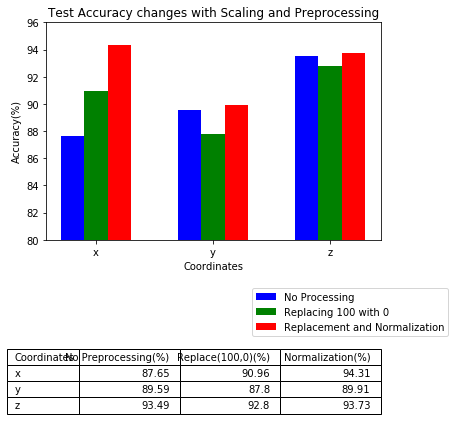

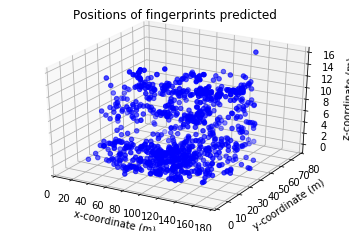

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar([-0.2,0.8,1.8], scale_acc_noprs,width=0.2,color='b',label='No Processing',align='center')
ax.bar(range(0,3), scale_acc_noscale,width=0.2,color='g',label='Replacing 100 with 0',align='center')
ax.bar([0.2,1.2,2.2], scale_acc_standard,width=0.2,color='r',label='Replacement and Normalization',align='center')
ax.set_title('Test Accuracy changes with Scaling and Preprocessing');
ax.set_xlabel('Coordinates');
ax.set_ylabel('Accuracy(%)');
plt.xticks(range(0,3),['x','y','z'])
row_labels=['Coordinates','x','y','z']
table_vals=[['No Preprocessing(%)','Replace(100,0)(%)','Normalization(%)'],
            [float('{0:.2f}'.format(scale_acc_noprs[0])),float('{0:.2f}'.format(scale_acc_noscale[0])),float('{0:.2f}'.format(scale_acc_standard[0]))],
            [float('{0:.2f}'.format(scale_acc_noprs[1])),float('{0:.2f}'.format(scale_acc_noscale[1])),float('{0:.2f}'.format(scale_acc_standard[1]))],
            [float('{0:.2f}'.format(scale_acc_noprs[2])),float('{0:.2f}'.format(scale_acc_noscale[2])),float('{0:.2f}'.format(scale_acc_standard[2]))]]
the_table = plt.table(cellText=table_vals,
                  rowLabels=row_labels,colWidths=[0.4]*3,
                  loc='right',bbox=[0.1, -0.8, 0.9, 0.3])
plt.text(80,4.0,'',size=100)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10) 
ax.set_ylim([80,96])
plt.legend(bbox_to_anchor=(0.6,-0.2))
plt.draw()
fig.savefig('scaling.png', bbox_inches='tight')

#conclusion
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mlp_x.predict(test_data_scale),mlp_y.predict(test_data_scale),mlp_z.predict(test_data_scale), c='b', marker='o')
ax.set_title('Positions of fingerprints predicted')
ax.set_xlabel('x-coordinate (m)')
ax.set_ylabel('y-coordinate (m)')
ax.set_zlabel('z-coordinate (m)')
ax.axis([0,180,0,80])
plt.draw()
fig.savefig('fingerprints_prediction.png', bbox_inches='tight')




<a id="7"></a>
### 7. Experiments: Effect of Feature Selection

Feature Selection is selecting those features which are most relevant to the target to build our model. We have a large number of APs(or features) in our data set. Around 200 Aps do not hear more than 3 data points as we can guess from the graphs above. Moreover, one AP may have multiple addresses and can get registered as multiple APs. Reducing the number of inputs to the ANN by rejecting features having least relation with the target variable, can help in improving the accuracy of prediction, reducing training times and reduce overfitting. 

In [12]:
from sklearn.feature_selection import f_regression

# we do the feature selection for all the three coordinates
# the code below repeats for x, y and z coordinates
X, y = train_data_scale, train_target_x_org
print(X.shape)
train_data1 = train_data_scale.copy(deep=True)
train_data2 = train_data_scale.copy(deep=True)
test_data1 = test_data_scale.copy(deep=True)
test_data2 = test_data_scale.copy(deep=True)
f_value = f_regression(X, y, center=True)
c = [0,0,0,0]
A = np.sort(f_value[0])
k = 292
mini = A[k]

for i in range (0,992):
    if A[i]<=mini:
        del train_data1[i]
        del test_data1[i]
        i = i-1
print(train_data1.shape)
A = np.sort(f_value[0])
k = 692
mini = A[k]
for i in range (0,992):
    if f_value[0][i]<=mini:
        del train_data2[i]
        del test_data2[i]
        i = i-1
print(train_data2.shape)
xfeaturesel = [0.0,0.0]
from sklearn.neural_network import MLPRegressor
mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,100,20), max_iter=200)     
mlp_x.fit(train_data1,train_target_x_org)
xfeaturesel[0] = mlp_x.score(test_data1, test_target_x_org)*100   

mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,100,20), max_iter=200)     
mlp_x.fit(train_data2,train_target_x_org)
xfeaturesel[1] = mlp_x.score(test_data2, test_target_x_org)*100   
#
#
#
#
from sklearn.feature_selection import f_regression
X, y = train_data_scale, train_target_y_org
print(X.shape)
train_data1 = train_data_scale.copy(deep=True)
train_data2 = train_data_scale.copy(deep=True)
test_data1 = test_data_scale.copy(deep=True)
test_data2 = test_data_scale.copy(deep=True)
f_value = f_regression(X, y, center=True)
A = np.sort(f_value[0])
k = 292
#$idx = np.argpartition(A, k)
mini = A[k]

for i in range (0,992):
#    if i==(train_data1.shape[1]-1):
#        break
    if f_value[0][i]<=mini:
        del train_data1[i]
        del test_data1[i]
        i = i-1
print(train_data1.shape)

A = np.sort(f_value[0])
k = 692
mini = A[k]
for i in range (0,992):
#    if i==(train_data2.shape[1]-1):
#        break
    if f_value[0][i]<=mini:
        del train_data2[i]
        del test_data2[i]
        i = i-1
print(train_data2.shape)
yfeaturesel = [0.0,0.0]
from sklearn.neural_network import MLPRegressor
mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,50,20), max_iter=200)     
mlp_x.fit(train_data1,train_target_y_org)
yfeaturesel[0] = mlp_x.score(test_data1, test_target_y_org)*100   

mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,50,20), max_iter=200)     
mlp_x.fit(train_data2,train_target_y_org)
yfeaturesel[1] = mlp_x.score(test_data2, test_target_y_org)*100   
#
#
#

from sklearn.feature_selection import f_regression
X, y = train_data_scale, train_target_z_org
print(X.shape)
train_data1 = train_data_scale.copy(deep=True)
train_data2 = train_data_scale.copy(deep=True)
test_data1 = test_data_scale.copy(deep=True)
test_data2 = test_data_scale.copy(deep=True)
f_value = f_regression(X, y, center=True)
A = np.sort(f_value[0])
k = 292
mini = A[k]
for i in range (0,992):
#    if i==(train_data1.shape[1]-1):
#        break
    if f_value[0][i]<=mini:
        del train_data1[i]
        del test_data1[i]
        i = i-1
print(train_data1.shape)
A = np.sort(f_value[0])
k = 692

mini = A[k]
for i in range (0,992):
#    if i==(train_data2.shape[1]-1):
#        break
    if f_value[0][i]<=mini:
        del train_data2[i]
        del test_data2[i]
        i = i-1
    
print(train_data2.shape)
zfeaturesel = [0.0,0.0]
from sklearn.neural_network import MLPRegressor
mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,50,20), max_iter=200)     
mlp_x.fit(train_data1,train_target_z_org)
zfeaturesel[0] = mlp_x.score(test_data1, test_target_z_org)*100   

mlp_x = MLPRegressor(hidden_layer_sizes=(200,200,200,100,50,20), max_iter=200)     
mlp_x.fit(train_data2,train_target_z_org)
zfeaturesel[1] = mlp_x.score(test_data2, test_target_z_org)*100



print(xfeaturesel)
print(yfeaturesel)
print(zfeaturesel)

(3718, 992)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
corr /= X_norms
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
r/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
cond2 = cond0 & (x <= self.a)

(3718, 699)
(3718, 299)
(3718, 992)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
corr /= X_norms
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
return (self

### Graph showing effect of Feature Selection on prediction accuracy
The graph below shows the effect of feature selection on the x, y, and z prediction. Though, the prediction accuracy did not increase significantly in our case but the results are comparable for the x and z coordinates, even after reducing the feature space(input nodes) by two-thirds, which shows that a lot of the APs were redundant. Nevertheless, there was a increase in positioning error(significant increase for y coordinate) with decreasing the number of APs (features), which implies all APs should be considered with equal importance in this dataset.


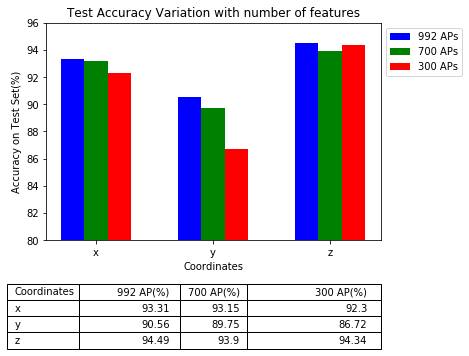

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar([-0.2,0.8,1.8], scale_acc_standard,width=0.2,color='b',label='992 APs',align='center')
ax.bar(range(0,3), [xfeaturesel[0],yfeaturesel[0],zfeaturesel[0]],width=0.2,color='g',label='700 APs',align='center')
ax.bar([0.2,1.2,2.2], [xfeaturesel[1],yfeaturesel[1],zfeaturesel[1]],width=0.2,color='r',label='300 APs',align='center')
ax.set_title('Test Accuracy Variation with number of features');
ax.set_xlabel('Coordinates');
ax.set_ylabel('Accuracy on Test Set(%)');
plt.xticks(range(0,3),['x','y','z'])
row_labels=['Coordinates','x','y','z']
table_vals=[['992 AP(%)','700 AP(%)','300 AP(%)'],
            [float('{0:.2f}'.format(scale_acc_standard[0])),float('{0:.2f}'.format(xfeaturesel[0])),float('{0:.2f}'.format(xfeaturesel[1]))],
            [float('{0:.2f}'.format(scale_acc_standard[1])),float('{0:.2f}'.format(yfeaturesel[0])),float('{0:.2f}'.format(yfeaturesel[1]))],
            [float('{0:.2f}'.format(scale_acc_standard[2])),float('{0:.2f}'.format(zfeaturesel[0])),float('{0:.2f}'.format(zfeaturesel[1]))]]
the_table = plt.table(cellText=table_vals,
                  rowLabels=row_labels,colWidths=[0.3,0.2,0.4],
                  loc='right',bbox=[0.1, -0.5, 0.9, 0.3])
plt.text(80,4.0,'',size=100)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10) 
ax.set_ylim([80,96])
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.draw()
fig.savefig('featuresel.png', bbox_inches='tight')